# Execução do modelo

In [1]:
import matplotlib.pyplot as plt
import pandas as pd


plt.style.use('fivethirtyeight')

## Inicializando parâmetros

In [2]:
ALL_DATAFRAMES_STR = [
    'model'
]

LABEL_STR = 'qt_sales'

INDEX_COLUMNS = ['PRODUCTCODE', 'YEAR_MONTH']

START_DATE = '2003-01-01'
END_DATE = '2005-01-01'


### Baseline

In [3]:
df = pd.read_parquet(f'../data/temp/df_model.parquet')

df_baseline = df[INDEX_COLUMNS + ['qt_sales', 'qt_sales_mavg_6']].copy()
df_baseline.loc[df_baseline['YEAR_MONTH']
                < START_DATE, 'cd_sample'] = 'train'
df_baseline.loc[
    (df_baseline['YEAR_MONTH'] >= START_DATE) &
    (df_baseline['YEAR_MONTH'] < END_DATE), 'cd_sample'] = 'test'
df_baseline.loc[:, 'cd_model'] = 'moving_avg_6'

df_baseline.rename(columns={
    'qt_sales': 'nu_label',
    'qt_sales_mavg_6': 'nu_predict'
}, inplace=True)


/var/folders/2w/j923ttcn15b8tdlsrwx0h7400000gn/T/ipykernel_14187/2782022376.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_baseline.loc[df_baseline['YEAR_MONTH']


In [4]:
df_all_predictions = pd.read_parquet('../models/2023_10_15/model/predictions/df_all_predictions.parquet')
df_all_predictions = pd.concat([df_all_predictions, df_baseline])

In [5]:
def get_wape(df, groupby=['cd_model', 'cd_sample']):
    df_errors = df.copy()

    df_errors['nu_diff'] = (
        df_errors['nu_label'] - df_errors['nu_predict']
    ).abs()
    df_errors['nu_label'] = df_errors['nu_label'].abs()

    df_errors = df_errors.groupby(groupby).agg(
        nu_diff=('nu_diff', 'sum'),
        nu_label=('nu_label', 'sum')
    )
    df_errors['nu_wape'] = df_errors['nu_diff']/df_errors['nu_label']
    
    return df_errors[['nu_wape']]


In [6]:
get_wape(df_all_predictions)

nu_wape
cd_model      cd_sample          
moving_avg_6  test       0.794197
random_forest test       0.718228
              train      0.242993
xgboost       test       0.725910
              train      0.058475

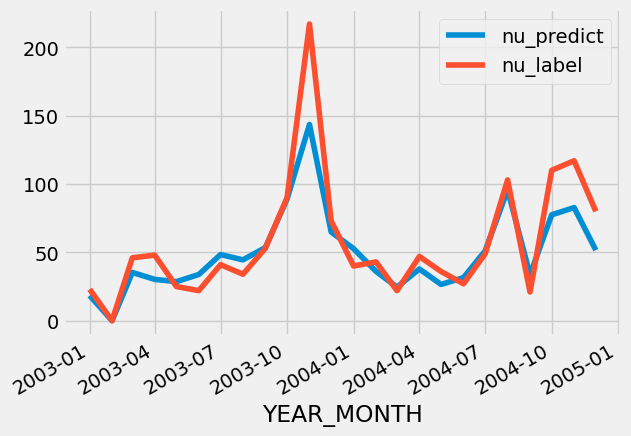

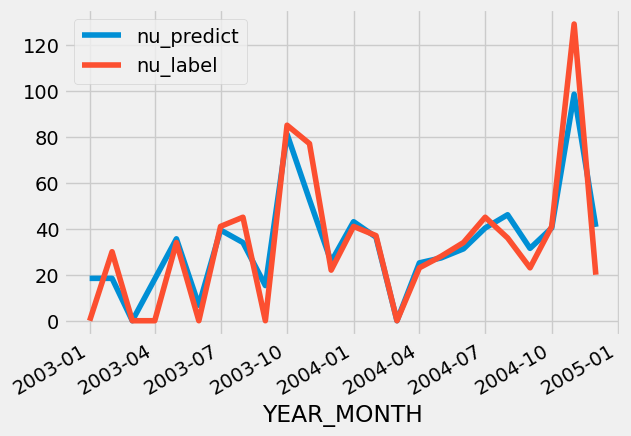

In [10]:
product_1 = 'S18_3232'
product_2 = 'S10_1678'

df_all_predictions[
    (df_all_predictions['PRODUCTCODE'] == product_1) &
    (df_all_predictions['cd_model'] == 'random_forest')
].set_index('YEAR_MONTH')['nu_predict'].plot(legend=True)
df_all_predictions[
    (df_all_predictions['PRODUCTCODE'] == product_1) &
    (df_all_predictions['cd_model'] == 'random_forest')
].set_index('YEAR_MONTH')['nu_label'].plot(legend=True)
plt.show()

df_all_predictions[
    (df_all_predictions['PRODUCTCODE'] == product_2) &
    (df_all_predictions['cd_model'] == 'random_forest')
].set_index('YEAR_MONTH')['nu_predict'].plot(legend=True)
df_all_predictions[
    (df_all_predictions['PRODUCTCODE'] == product_2) &
    (df_all_predictions['cd_model'] == 'random_forest')
].set_index('YEAR_MONTH')['nu_label'].plot(legend=True)
plt.show()


In [11]:
all_features = pd.read_pickle('../models/2023_10_15/model/features.pickle')
all_features

{'features': ['qt_sales_lag_1',
  'qt_sales_lag_2',
  'qt_sales_lag_3',
  'qt_sales_lag_4',
  'qt_sales_lag_5',
  'qt_sales_lag_6',
  'qt_sales_mavg_3',
  'qt_sales_mavg_6'],
 'index_cols': ['PRODUCTCODE', 'YEAR_MONTH'],
 'feature_importance': {'xgboost': {'qt_sales_lag_5': 0.17370115,
   'qt_sales_lag_6': 0.1490924,
   'qt_sales_lag_3': 0.14011157,
   'qt_sales_lag_2': 0.12244652,
   'qt_sales_mavg_3': 0.11501857,
   'qt_sales_lag_4': 0.10896252,
   'qt_sales_lag_1': 0.10289862,
   'qt_sales_mavg_6': 0.08776865},
  'random_forest': {'qt_sales_lag_1': 0.1493260665176439,
   'qt_sales_mavg_6': 0.13880736904653232,
   'qt_sales_mavg_3': 0.13647431100565055,
   'qt_sales_lag_5': 0.12916608772062055,
   'qt_sales_lag_2': 0.12633196839172112,
   'qt_sales_lag_3': 0.12207238214438954,
   'qt_sales_lag_6': 0.10281018868853621,
   'qt_sales_lag_4': 0.09501162648490577}}}